In [32]:
import numpy as np, pandas as pd

%load_ext autoreload
%autoreload 2

label_dict = {
    0: 'T-shirt/top',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle boot'
}

tr = pd.read_parquet('train.parquet').sample(20000, random_state=911).reset_index(drop=True)
tst = pd.read_parquet('test.parquet').sample(5000, random_state=911).reset_index(drop=True)
tr.label = tr.label.map(label_dict).astype('category')
tst.label = tst.label.map(label_dict).astype('category')

tr.info()
tr.head(3)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Columns: 785 entries, label to pixel784
dtypes: category(1), int64(784)
memory usage: 119.6 MB


,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,Bag,0,0,0,0,0,0,0,0,0,...,206,203,201,174,0,0,0,0,0,0
1,Trouser,0,0,0,0,0,0,0,0,0,...,19,0,0,0,0,0,0,0,0,0
2,Sneaker,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Посмотрим на данные

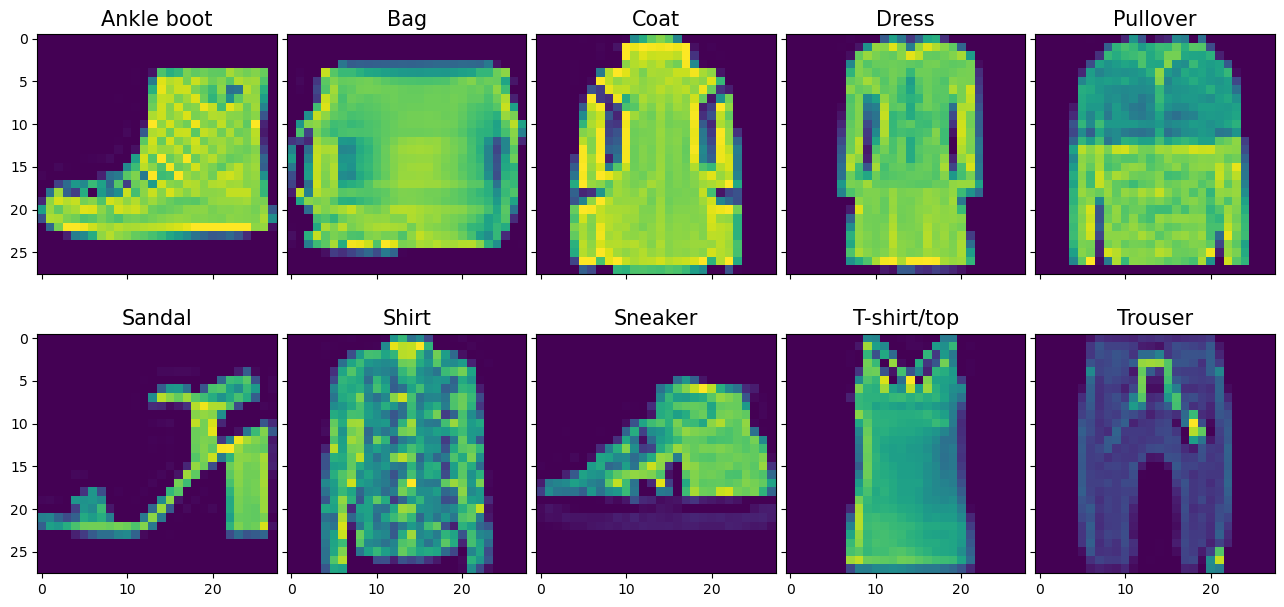

In [33]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

def plot_img(X, idx, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(5, 5))

    ax.set_title(X.loc[idx, 'label'], fontsize=15)
    ax.imshow(X.iloc[idx, 1:].values.astype(np.int32).reshape(28, 28))

fig = plt.figure(figsize=(20., 7))
grid = ImageGrid(fig, 111, nrows_ncols=(2, 5), axes_pad=(0.1, 0.6))

class_examples = tr.groupby('label', observed=True).sample(1, random_state=911)
images, labels = class_examples.iloc[:, 1:].values.astype(np.int32), class_examples.label

for i, (ax, im) in enumerate(zip(grid, images)):
    ax.set_title(labels.iloc[i], fontsize=15)
    ax.imshow(im.reshape(28, 28))

In [34]:
X_tr, y_tr, X_val, y_val = tr.iloc[:, 1:].values.astype(np.int64), tr.label.cat.codes.values, \
                            tst.iloc[:, 1:].values.astype(np.int64), tst.label.cat.codes.values

print('tr shape:', X_tr.shape, 'val shape:', X_val.shape)

tr shape: (20000, 784) val shape: (5000, 784)


# Глава 1

## Часть ^:. Памятка чайника на тему поиска соседей

**Постановка задачи:**
- дана обучающая выборка X_tr, тестовая X_val, число k, метрика M
- для каждого объекта из X_val (будем называть один такой объект символом q) нужно найти k ближайших соседей по метрике (функции близости) М из X_tr

**Характеристики алгоритмов поиска ближайших соседей:**
1) поддерживаемые функции близости
    - brute: любые
2) время построения индекса
    - индекс - специальная структура данных (обычно - надстройка над X_tr) для [быстрого] поиска соседей в ней
    - brute: индекс = X_tr
3) необходимая оперативная память для поддержания индекса
    - brute: data
4) время поиска k ближайших соседей для q
    - brute: X_tr подсчетов метрики M + выбор k минимальных для каждого q
5) точность найденных соседей
    - на самом деле полнота, а не точность :)
    - `recall@k(q) = |set_intersect(predicted_nn_idx(q), true_nn_idx(q))| / k` для одного q
        - predicted_nn_idx(q) ~ предсказанные алгоритмом индексы k ближ. соседей
        - true_nn_idx(q) ~ истинные индексы k ближ. соседей = те, что предсказал brute-алгоритм
    - Для X_val считаем средний recall@k по всем q
    - brute: `recall@k = 1`

## Часть 0. Брут (0_0)

- индекс:
    вся выборка
- поиск соседей:
    - посчитать попарные расстояния X_tr x X_val
    - найти соседей как аргмин расстояний

In [35]:
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import balanced_accuracy_score
from utils import Timer

k = 11
knn = NearestNeighbors(n_neighbors=k, algorithm='brute', metric='euclidean')

timer = Timer()
knn.fit(X_tr, y_tr)
timer.tick('BRUTE | fit_time', reset=True)

predicted_nn_idx = knn.kneighbors(X_val, return_distance=False)
timer.tick('BRUTE | search_time', reset=True)

from utils import knn_predict_classification
y_pred = knn_predict_classification(predicted_nn_idx, y_tr, n_classes=10)
timer.tick('func: knn_predict_classification')

print('balanced accuracy of brute:', round(balanced_accuracy_score(y_val, y_pred), 3))

BRUTE | fit_time: 0.018 sec
BRUTE | search_time: 1.701 sec
func: knn_predict_classification: 0.001 sec
balanced accuracy of brute: 0.837


Проблемы:
1) размеры матрицы расстояний = (tr.shape, val.shape)
   - лечение: batched knn (вшито в sklearn)
2) скорость вычисления попарных расстояний
3) хранение всей выборки

Плюсы:
1) найденные соседи реально ближайшие (без шуток)
2) любые функции близости
3) индекс строится за 0 сек!

## Часть 1. KDTree  \_\_)+_+)__/

In [36]:
from sklearn.neighbors import KDTree

KDTree.valid_metrics

['euclidean',
 'l2',
 'minkowski',
 'p',
 'manhattan',
 'cityblock',
 'l1',
 'chebyshev',
 'infinity']

In [37]:
knn = NearestNeighbors(n_neighbors=k, algorithm='kd_tree', metric='euclidean')
timer.reset()

knn.fit(X_tr, y_tr)
timer.tick('KDTree | fit_time', reset=True)

predicted_nn_idx = knn.kneighbors(X_val, return_distance=False)
timer.tick('KDTree | search_time')

from utils import knn_predict_classification
y_pred = knn_predict_classification(predicted_nn_idx, y_tr, n_classes=10)

print('balanced accuracy of kd_tree:', round(balanced_accuracy_score(y_val, y_pred), 3))

KDTree | fit_time: 2.635 sec
KDTree | search_time: 82.171 sec
balanced accuracy of kd_tree: 0.837


Проблемы:
1) ненулевое время построения индекса :)
2) скорость поиска
3) хранение всей выборки + хранение дерева
4) ограниченные функции близости
   
Плюсы:

(/^/__/^/)

## Часть 2. AnnPlotter (^(*)-(\*)^)

In [38]:
from utils import AnnPlotter

plotter = AnnPlotter(X_tr, y_tr, k=11, metric='euclidean', n_classes=10)
plotter.calc_true_nn(X_val, y_val)

Brute | search_time: 1.714 sec


In [39]:
%time plotter.prepare_sklearn(X_val, y_val, name='KDTree', leaf_sizes=[30, 100, 500, 1000], algorithm='kd_tree', metric='euclidean')


KDTree.leaf_size=30 | build_time: 2.66 sec
KDTree.leaf_size=30 | search_time: 82.307 sec

KDTree.leaf_size=100 | build_time: 2.111 sec
KDTree.leaf_size=100 | search_time: 68.941 sec

KDTree.leaf_size=500 | build_time: 1.557 sec
KDTree.leaf_size=500 | search_time: 64.259 sec

KDTree.leaf_size=1000 | build_time: 1.273 sec
KDTree.leaf_size=1000 | search_time: 62.61 sec
CPU times: total: 4min 45s
Wall time: 4min 45s


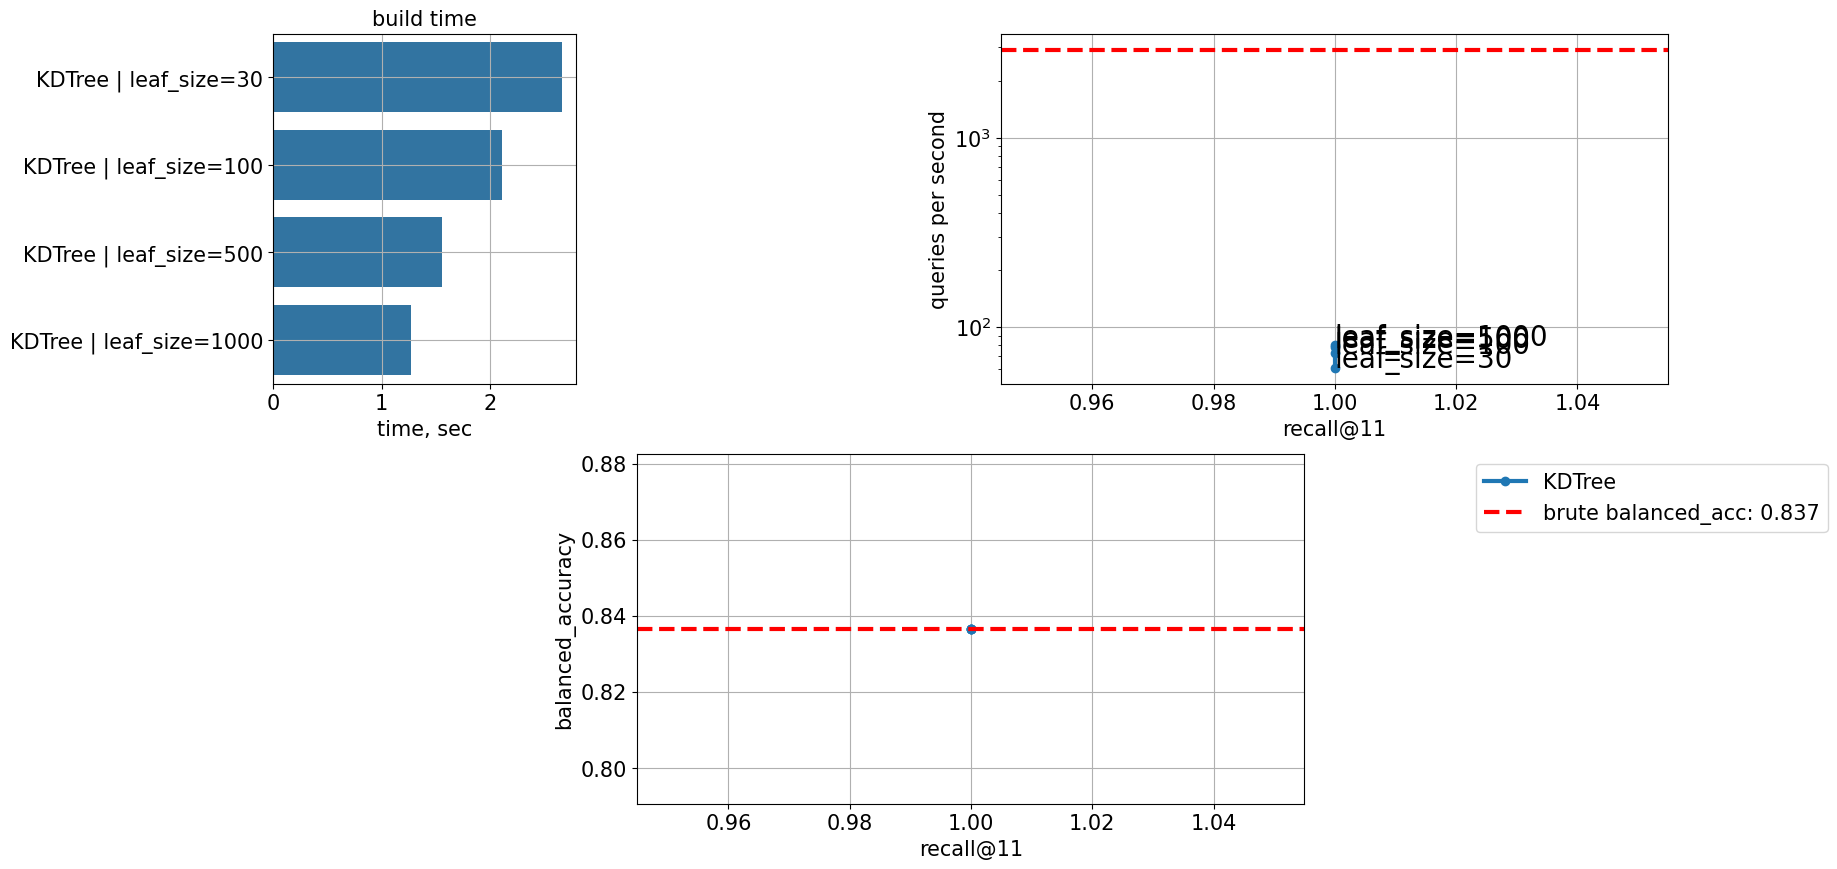

In [40]:
plotter.show()

## Часть 3. LSH (\\_(l_l)_/). Locally-Sensitive Hashing

[**FALCONN**](https://github.com/FALCONN-LIB/FALCONN) - LSH Families for cosine similarity* (библиотека мертва)

Реализовано [тут](https://github.com/facebookresearch/faiss/wiki/Faiss-indexes)
  
  2015 - Practical and Optimal LSH for Angular Distance https://arxiv.org/abs/1509.02897
  
  Туториал по `LSH` и его реализации в библиотеке (оно же, коротко и ясно):
  
  https://github.com/FALCONN-LIB/FALCONN/wiki/LSH-Primer <br>
  https://github.com/FALCONN-LIB/FALCONN/wiki/LSH-Families
  
  
[**datasketch**](https://github.com/ekzhu/datasketch) - LSH Family for Jaccard similarity

In [41]:
%time plotter.prepare_lsh(X_val, y_val, name='LSH', nbits=[10, 50, 200, 784, 784 * 2, 784 * 4, 784 * 8])


LSH. nbit=10 | build_time: 0.047 sec
LSH. nbit=10 | search_time: 0.081 sec

LSH. nbit=50 | build_time: 0.049 sec
LSH. nbit=50 | search_time: 0.102 sec

LSH. nbit=200 | build_time: 0.067 sec
LSH. nbit=200 | search_time: 0.096 sec

LSH. nbit=784 | build_time: 0.126 sec
LSH. nbit=784 | search_time: 0.162 sec

LSH. nbit=1568 | build_time: 0.209 sec
LSH. nbit=1568 | search_time: 0.246 sec

LSH. nbit=3136 | build_time: 0.355 sec
LSH. nbit=3136 | search_time: 0.47 sec

LSH. nbit=6272 | build_time: 0.685 sec
LSH. nbit=6272 | search_time: 0.834 sec
CPU times: total: 58.2 s
Wall time: 7.47 s


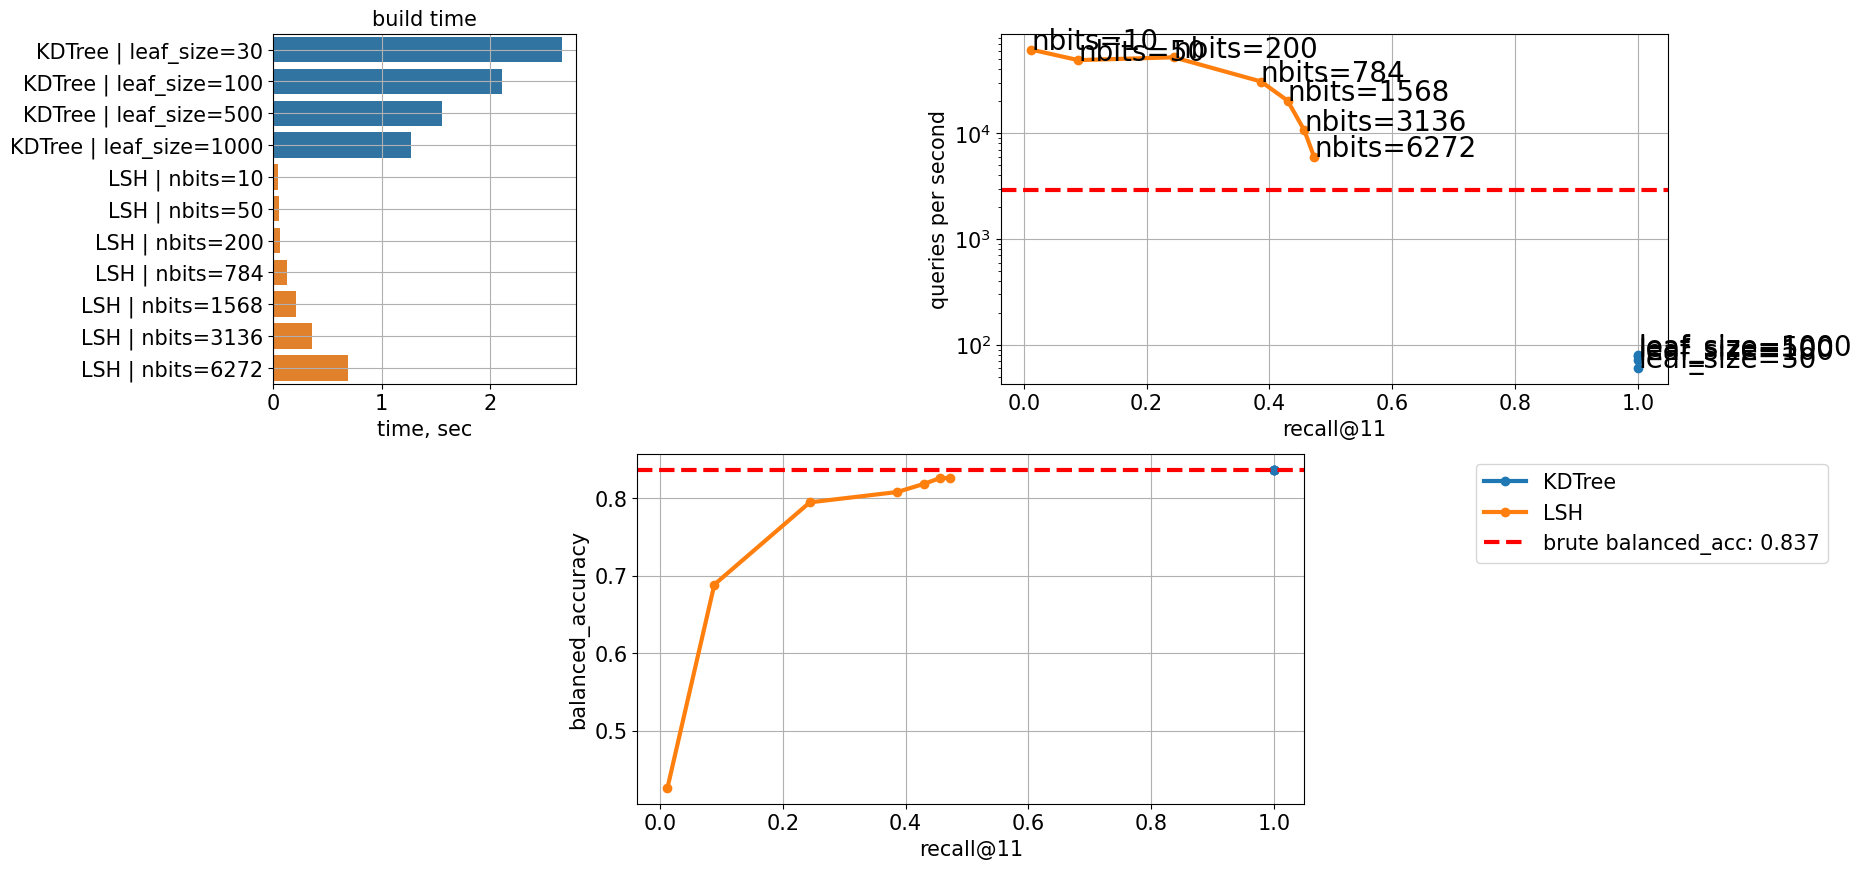

In [42]:
plotter.show()

Проблемы:
1) при скоростях существенно бОльших brute_qps качество плохое
2) в теории: хранение всей выборки + L таблиц + KL хэш-функций
3) на практике для faiss.LSH: храним для каждого вектора только его ближайший базисный вектор = nbits
4) без multiprobe плохое качество для небольших nbits
5) на практике для faiss.LSH: функция близости = Hamming на базисных векторах-кодировках

Плюсы:
1) быстрое построение индекса
2) в теории: любые функции близости, главное подобрать locally-sensitive хэш-функции

## Часть 4. HNSW _/`-\_-7. Hierarchical Navigable Small World
  
[**nmslib**](https://github.com/nmslib/nmslib/) - Non-Metric Space Library (не ставится на винду)<br>
[**hnswlib**](https://github.com/nmslib/hnswlib)<br>
facebook::[**faiss**](https://github.com/facebookresearch/faiss/wiki/Faiss-indexes)<br>
spotify::[**voyager**](https://github.com/spotify/voyager), [habr](https://habr.com/ru/news/770308/) (у меня падает ядро на python 3.10 при add_items/add_item, но вы попробуйте!)
  
**Navigable Small World** <br>
  2013 - Approximate nearest neighbor algorithm based on navigable
small world graphs https://publications.hse.ru/pubs/share/folder/x5p6h7thif/128296059.pdf


**Hierarchical Navigable Small World** <br>
  2016 - Efficient and robust approximate nearest neighbor search using Hierarchical Navigable Small World graphs https://arxiv.org/abs/1603.09320


Разберем код:

In [43]:
import numpy as np

dim = 128
num_elements = 100_000

# Generating sample data
np.random.seed(911)
data = np.random.random((num_elements, dim)).astype(np.float32)
ids = np.arange(num_elements)

In [44]:
import hnswlib
from utils import Timer


# Declaring index
p = hnswlib.Index(space='l2', dim=dim) # possible options are l2, cosine or ip

# Initializing index - the maximum number of elements should be known beforehand
p.init_index(max_elements=num_elements, ef_construction=200, M=16)


timer = Timer()

# Element insertion (can be called several times):
p.add_items(data, ids)
timer.tick('Element insertion')



# Controlling the recall by setting ef:
p.set_ef(50) # ef should always be > k

query_size = 1000
query = data[:query_size]

# Query dataset, k - number of closest elements (returns 2 numpy arrays)
labels, distances = p.knn_query(query, k=3)

timer.tick('Query dataset')

print('\nlabels:\n', labels[:5])
print('\ndistances:\n', distances[:5])

Element insertion: 4.99 sec
Query dataset: 0.021 sec

labels:
 [[    0  1282 57404]
 [    1 51155 44628]
 [40012 75607 67964]
 [    3 65605 59762]
 [    4 90650 90863]]

distances:
 [[ 0.        12.8320055 13.142619 ]
 [ 0.        11.866396  12.505065 ]
 [15.148863  15.154925  15.194883 ]
 [ 0.        12.821472  13.108384 ]
 [ 0.        13.288245  13.621016 ]]


Сравнения между собой при разных гиперпараметрах

In [45]:
from utils import AnnPlotter

hnsw_plotter = AnnPlotter(X_tr, y_tr, k=11, metric='euclidean', n_classes=10)
hnsw_plotter.calc_true_nn(X_val, y_val)

Brute | search_time: 1.716 sec


In [46]:
ef_search_list = [2, 50, 500]
hnsw_plotter.prepare_hnswlib(X_val, y_val, name='hnswlib | efC=500. M=5', ef_construction=500, M=5, ef_search_list=ef_search_list)
hnsw_plotter.prepare_hnswlib(X_val, y_val, name='efC=10. M=5', ef_construction=10, M=5, ef_search_list=ef_search_list)
hnsw_plotter.prepare_hnswlib(X_val, y_val, name='efC=500. M=200', ef_construction=500, M=200, ef_search_list=ef_search_list)
hnsw_plotter.prepare_hnswlib(X_val, y_val, name='efC=10. M=200', ef_construction=10, M=200, ef_search_list=ef_search_list)


hnswlib | efC=500. M=5. ef_construction=500, M=5 | build_time: 0.874 sec
hnswlib | efC=500. M=5. ef_search=2 | search_time: 0.022 sec
hnswlib | efC=500. M=5. ef_search=50 | search_time: 0.048 sec
hnswlib | efC=500. M=5. ef_search=500 | search_time: 0.291 sec

efC=10. M=5. ef_construction=10, M=5 | build_time: 0.072 sec
efC=10. M=5. ef_search=2 | search_time: 0.018 sec
efC=10. M=5. ef_search=50 | search_time: 0.038 sec
efC=10. M=5. ef_search=500 | search_time: 0.207 sec

efC=500. M=200. ef_construction=500, M=200 | build_time: 1.601 sec
efC=500. M=200. ef_search=2 | search_time: 0.056 sec
efC=500. M=200. ef_search=50 | search_time: 0.135 sec
efC=500. M=200. ef_search=500 | search_time: 0.564 sec

efC=10. M=200. ef_construction=10, M=200 | build_time: 0.799 sec
efC=10. M=200. ef_search=2 | search_time: 0.052 sec
efC=10. M=200. ef_search=50 | search_time: 0.131 sec
efC=10. M=200. ef_search=500 | search_time: 0.503 sec


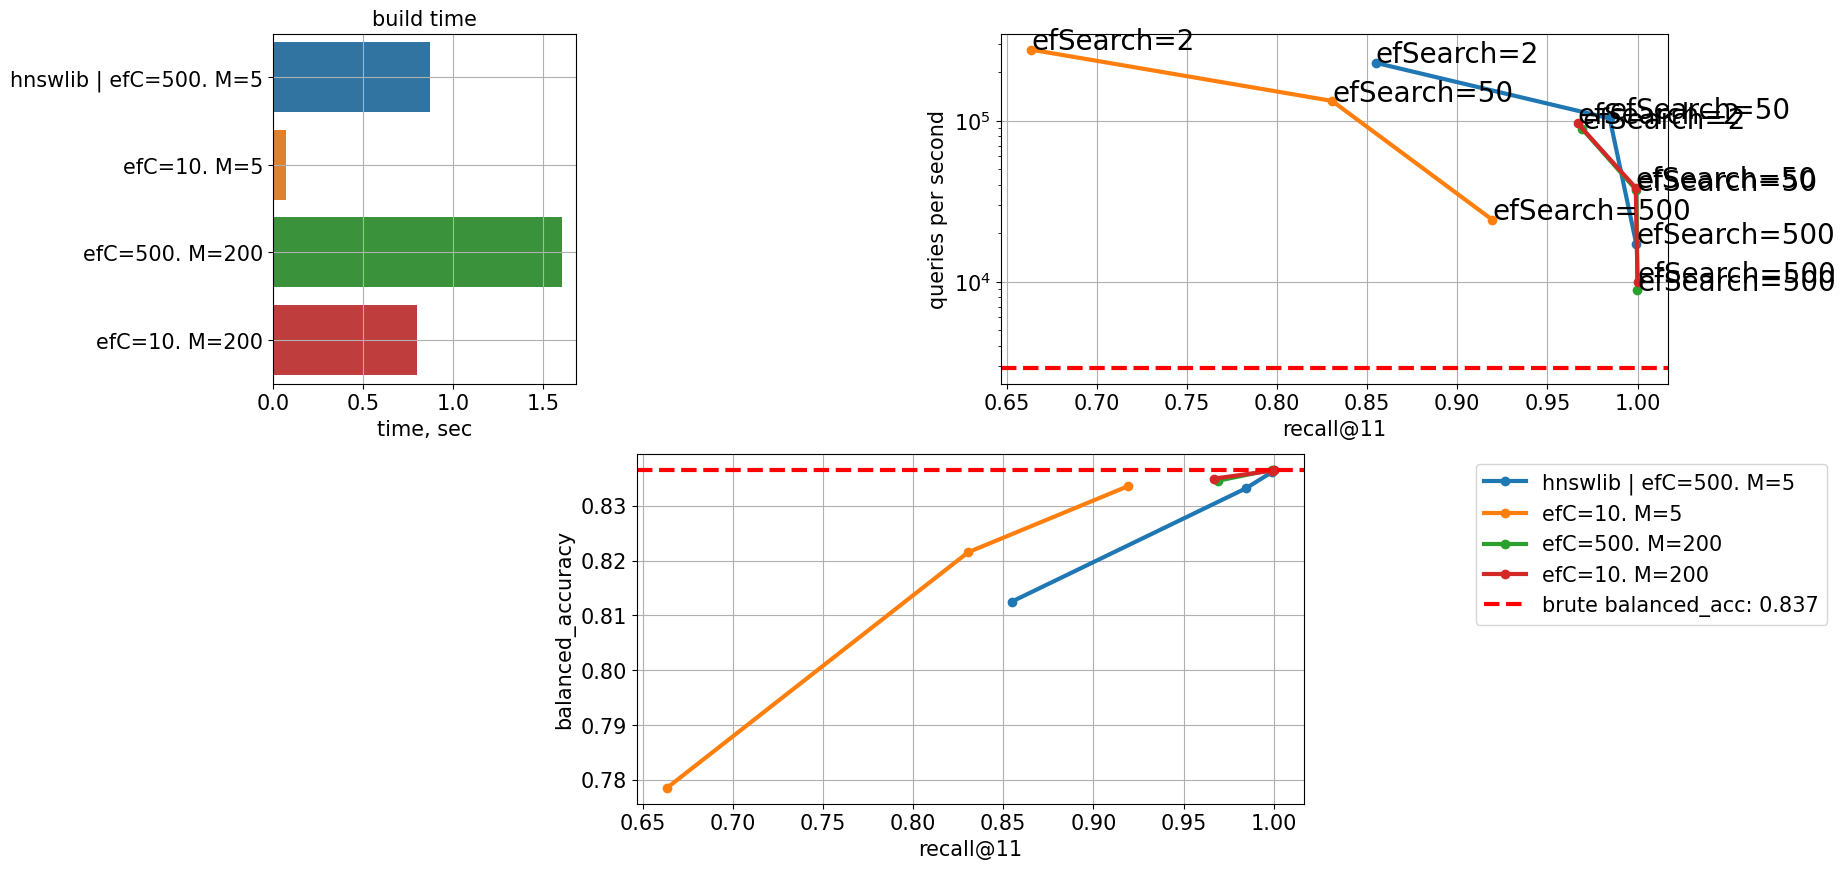

In [47]:
hnsw_plotter.show()

Сравнения с остальными:

In [48]:
%time plotter.prepare_hnswlib(X_val, y_val, name='HNSW', ef_construction=200, M=50, ef_search_list=[10, 50, 100, 500, 1000, 2000])


HNSW. ef_construction=200, M=50 | build_time: 0.616 sec
HNSW. ef_search=10 | search_time: 0.04 sec
HNSW. ef_search=50 | search_time: 0.101 sec
HNSW. ef_search=100 | search_time: 0.15 sec
HNSW. ef_search=500 | search_time: 0.417 sec
HNSW. ef_search=1000 | search_time: 0.674 sec
HNSW. ef_search=2000 | search_time: 1.139 sec
CPU times: total: 35.3 s
Wall time: 3.39 s


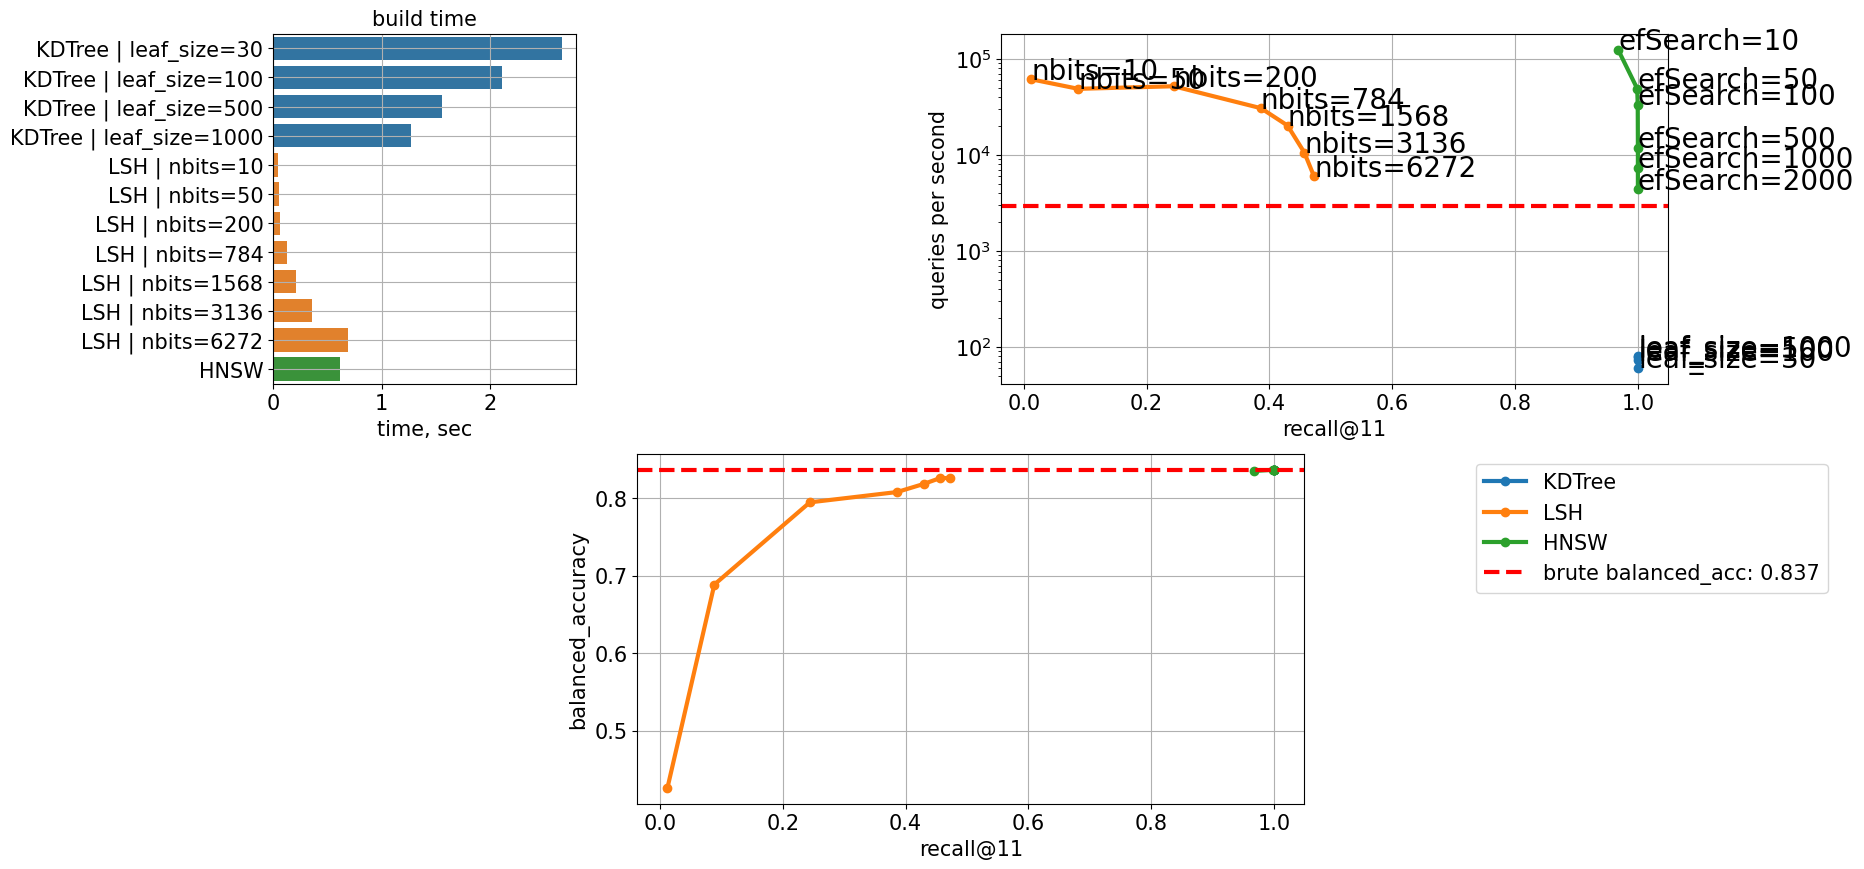

In [49]:
plotter.show()

Проблемы:
1) хранение всей выборки + хранение графа
2) на практике для hnswlib: только l2, cosine, inner-product функции близости

Плюсы:
1) адекватная скорость построение индекса
2) в теории: любые функции близости
3) отличная точность
4) отличная скорость поиска

In [50]:
%time plotter.prepare_voyager(X_val, y_val, name='Voyager', ef_construction=200, M=50, ef_search_list=[50, 100, 500, 1000, 2000])


Voyager. ef_construction=200, M=50 | build_time: 23.096 sec
Voyager. ef_search=50 | search_time: 3.591 sec
Voyager. ef_search=100 | search_time: 5.283 sec
Voyager. ef_search=500 | search_time: 12.628 sec
Voyager. ef_search=1000 | search_time: 18.896 sec
Voyager. ef_search=2000 | search_time: 26.73 sec
CPU times: total: 1min 30s
Wall time: 1min 30s


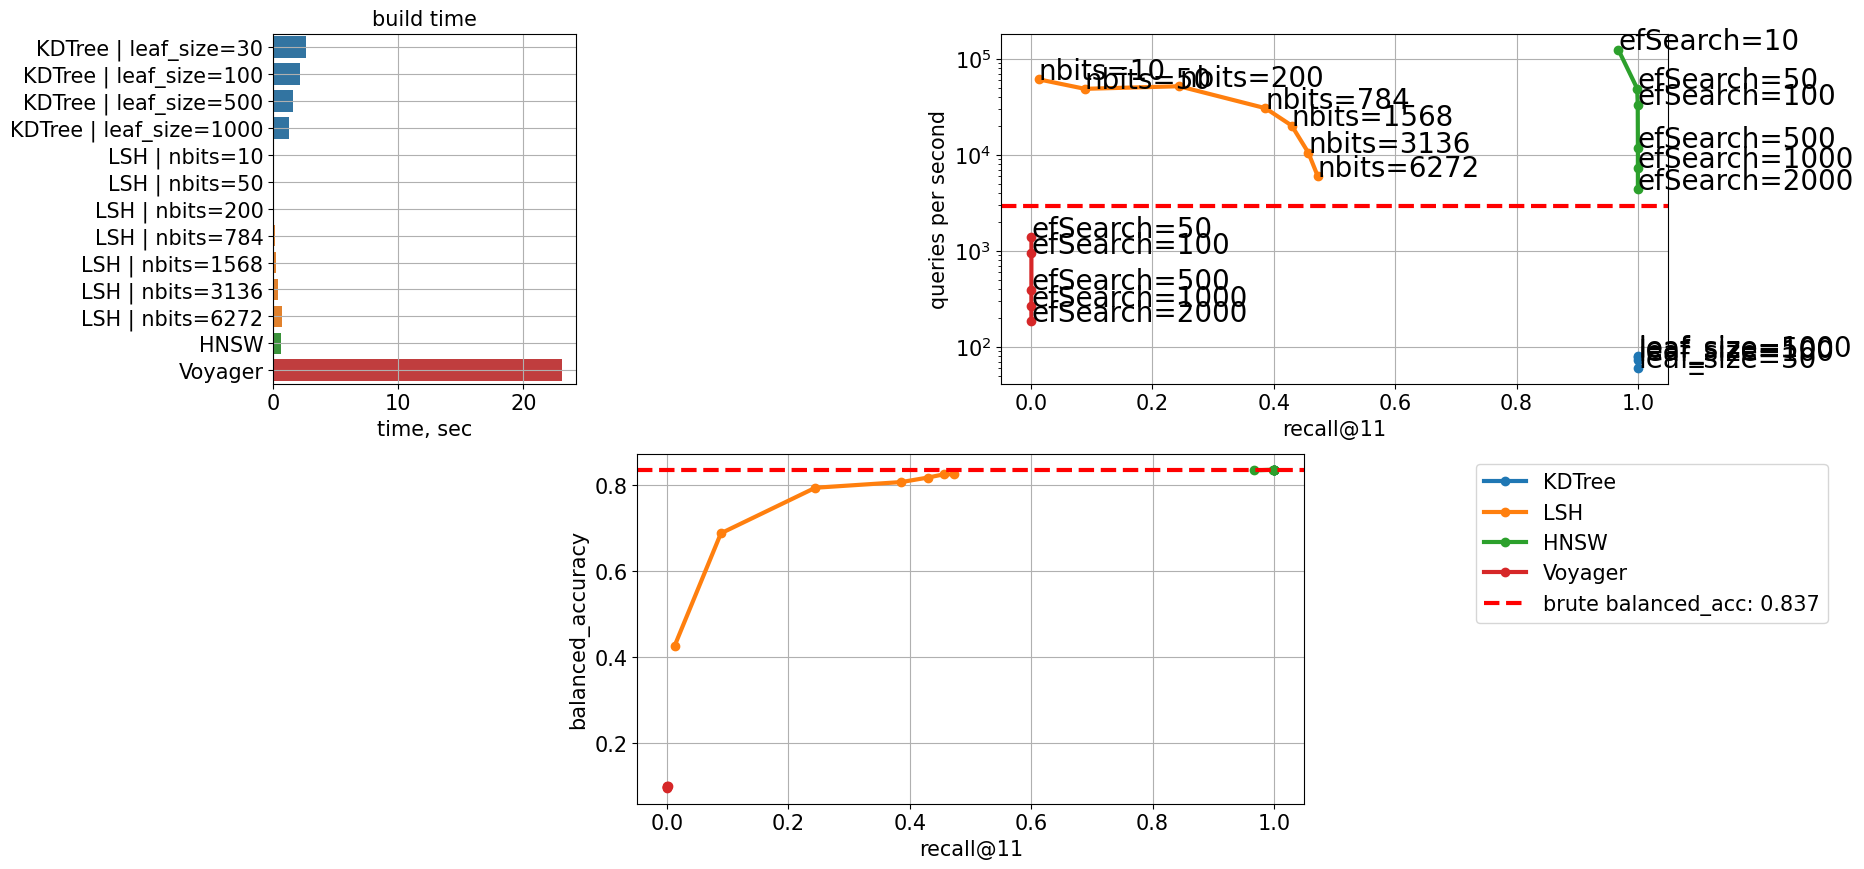

In [51]:
plotter.show()

In [52]:
ы

NameError: name 'ы' is not defined

# Глава 2

## Часть 5. Intro: [Tutte Institute](https://github.com/TutteInstitute) - главная экосистема анализа данных

<img src='img/intro.png'>

<br>
Leland McInnes - знаменитостей надо знать в лицо!<br>
<img src='img/superstar.jpg' width=200>

[intro2intro](https://youtu.be/r8dWZX8IGw8?si=nKuHuO8kj6GE0fQc) (youtube)

А также, приучаемся смотреть:
- [PyData](https://pydata.org) [[youtube](https://youtube.com/@pydatatv?si=jCsz1zEqKoQ6qHYe)]
- [SciPy](https://conference.scipy.org) [[youtube](https://youtube.com/@enthought?si=NYjm2Nl2SYfZ0iEI)]

## Часть 6. PyNNDescent ┬┴┬┴┤(･_├┬┴┬┴. [python + numba warrior] с поддержкой кастомных метрик

[github](https://github.com/lmcinnes/pynndescent) <br>
[документация](https://pynndescent.readthedocs.io/en/stable/how_pynndescent_works.html) + как это работает <br>
[видео-туториал](https://youtu.be/xPadY4_kt3o?si=GACgoA8RcU8GIcHf) от разработчика: Leland McInnes (youtube)

Разберем код:

In [ ]:
import pynndescent
from utils import Timer

timer = Timer()
index = pynndescent.NNDescent(
    data,
    metric='euclidean', # or callable!
    n_neighbors=30, # The number of neighbors to use in k-neighbor graph graph_data structure used for fast approximate nearest neighbor search.
                    # Larger values will result in more accurate search results at the cost of computation time.
    leaf_size=100, #The maximum number of points in a leaf for the random projection trees.
                    # The default of None means a value will be chosen based on n_neighbors.
    
    pruning_degree_multiplier=1.5, # How aggressively to prune the graph. Since the search graph is undirected (and thus includes nearest neighbors and reverse nearest neighbors) vertices can
                                # have very high degree – the graph will be pruned such that no vertex has degree greater than pruning_degree_multiplier * n_neighbors
    
    diversify_prob=1., # The search graph get “diversified” by removing potentially unnecessary edges. This controls the volume of edges removed.
                # A value of 0.0 ensures that no edges get removed, and larger values result in significantly more aggressive edge removal. A value of 1.0 will prune all edges that it can.
    verbose=True
)
timer.tick('init')

index.prepare()
timer.tick('prepare')

query_size = 1000
query = data[:query_size]

neighbors, distances = index.query(query, k=5)
timer.tick('query')

neighbors[:5], distances[:5]

Wed Nov 27 19:57:11 2024 Building RP forest with 23 trees
Wed Nov 27 19:57:14 2024 NN descent for 17 iterations
	 1  /  17
	 2  /  17
	 3  /  17
	 4  /  17
	 5  /  17
	 6  /  17
	 7  /  17
	 8  /  17
	 9  /  17
	 10  /  17
	 11  /  17
	Stopping threshold met -- exiting after 11 iterations
init: 19.503 sec
Wed Nov 27 19:57:37 2024 Worst tree score: 0.24683000
Wed Nov 27 19:57:37 2024 Mean tree score: 0.25005478
Wed Nov 27 19:57:37 2024 Best tree score: 0.25558000
Wed Nov 27 19:57:38 2024 Forward diversification reduced edges from 3000000 to 1720284
Wed Nov 27 19:57:41 2024 Reverse diversification reduced edges from 1720284 to 1720284
Wed Nov 27 19:57:43 2024 Degree pruning reduced edges from 2510024 to 2099721
Wed Nov 27 19:57:43 2024 Resorting data and graph based on tree order
Wed Nov 27 19:57:43 2024 Building and compiling search function
prepare: 13.868 sec
query: 0.115 sec


(array([[    0,  1282, 57404, 76386, 23478],
        [    1, 51155, 64368, 93524, 73056],
        [    2, 42788, 26825, 16061, 38334],
        [    3, 65605, 79081, 21697,  7261],
        [    4, 90650, 90863, 49693, 51501]]),
 array([[0.       , 3.582179 , 3.625275 , 3.6272664, 3.6343336],
        [0.       , 3.4447637, 3.6090326, 3.6103597, 3.619408 ],
        [0.       , 3.5784233, 3.7501166, 3.8153713, 3.8603482],
        [0.       , 3.5807085, 3.6613584, 3.672427 , 3.6821182],
        [0.       , 3.6453044, 3.690666 , 3.7448668, 3.7567601]],
       dtype=float32))

In [ ]:
from utils import AnnPlotter

pynndescent_plotter = AnnPlotter(X_tr, y_tr, k=11, metric='euclidean', n_classes=10)
pynndescent_plotter.calc_true_nn(X_val, y_val)

Brute | search_time: 1.962 sec


In [ ]:
# pynndescent_plotter.prepare_pynndescent(X_val, y_val, name='pynndescent_ls', leaf_size=[10, 100, 1000])
# pynndescent_plotter.prepare_pynndescent(X_val, y_val, name='pynndescent_pdm', pruning_degree_multiplier=[1., 1.5, 2, 5])
pynndescent_plotter.prepare_pynndescent(X_val, y_val, name='pynndescent_dp', diversify_prob=[0, 0.33, 0.66, 1])


pynndescent_dp. leaf_size=None, PDM=1.5, DP=0 | build_time: 3.057 sec
pynndescent_dp. | search_time: 0.414 sec

pynndescent_dp. leaf_size=None, PDM=1.5, DP=0.33 | build_time: 2.995 sec
pynndescent_dp. | search_time: 0.283 sec

pynndescent_dp. leaf_size=None, PDM=1.5, DP=0.66 | build_time: 2.705 sec
pynndescent_dp. | search_time: 0.231 sec

pynndescent_dp. leaf_size=None, PDM=1.5, DP=1 | build_time: 3.217 sec
pynndescent_dp. | search_time: 0.274 sec


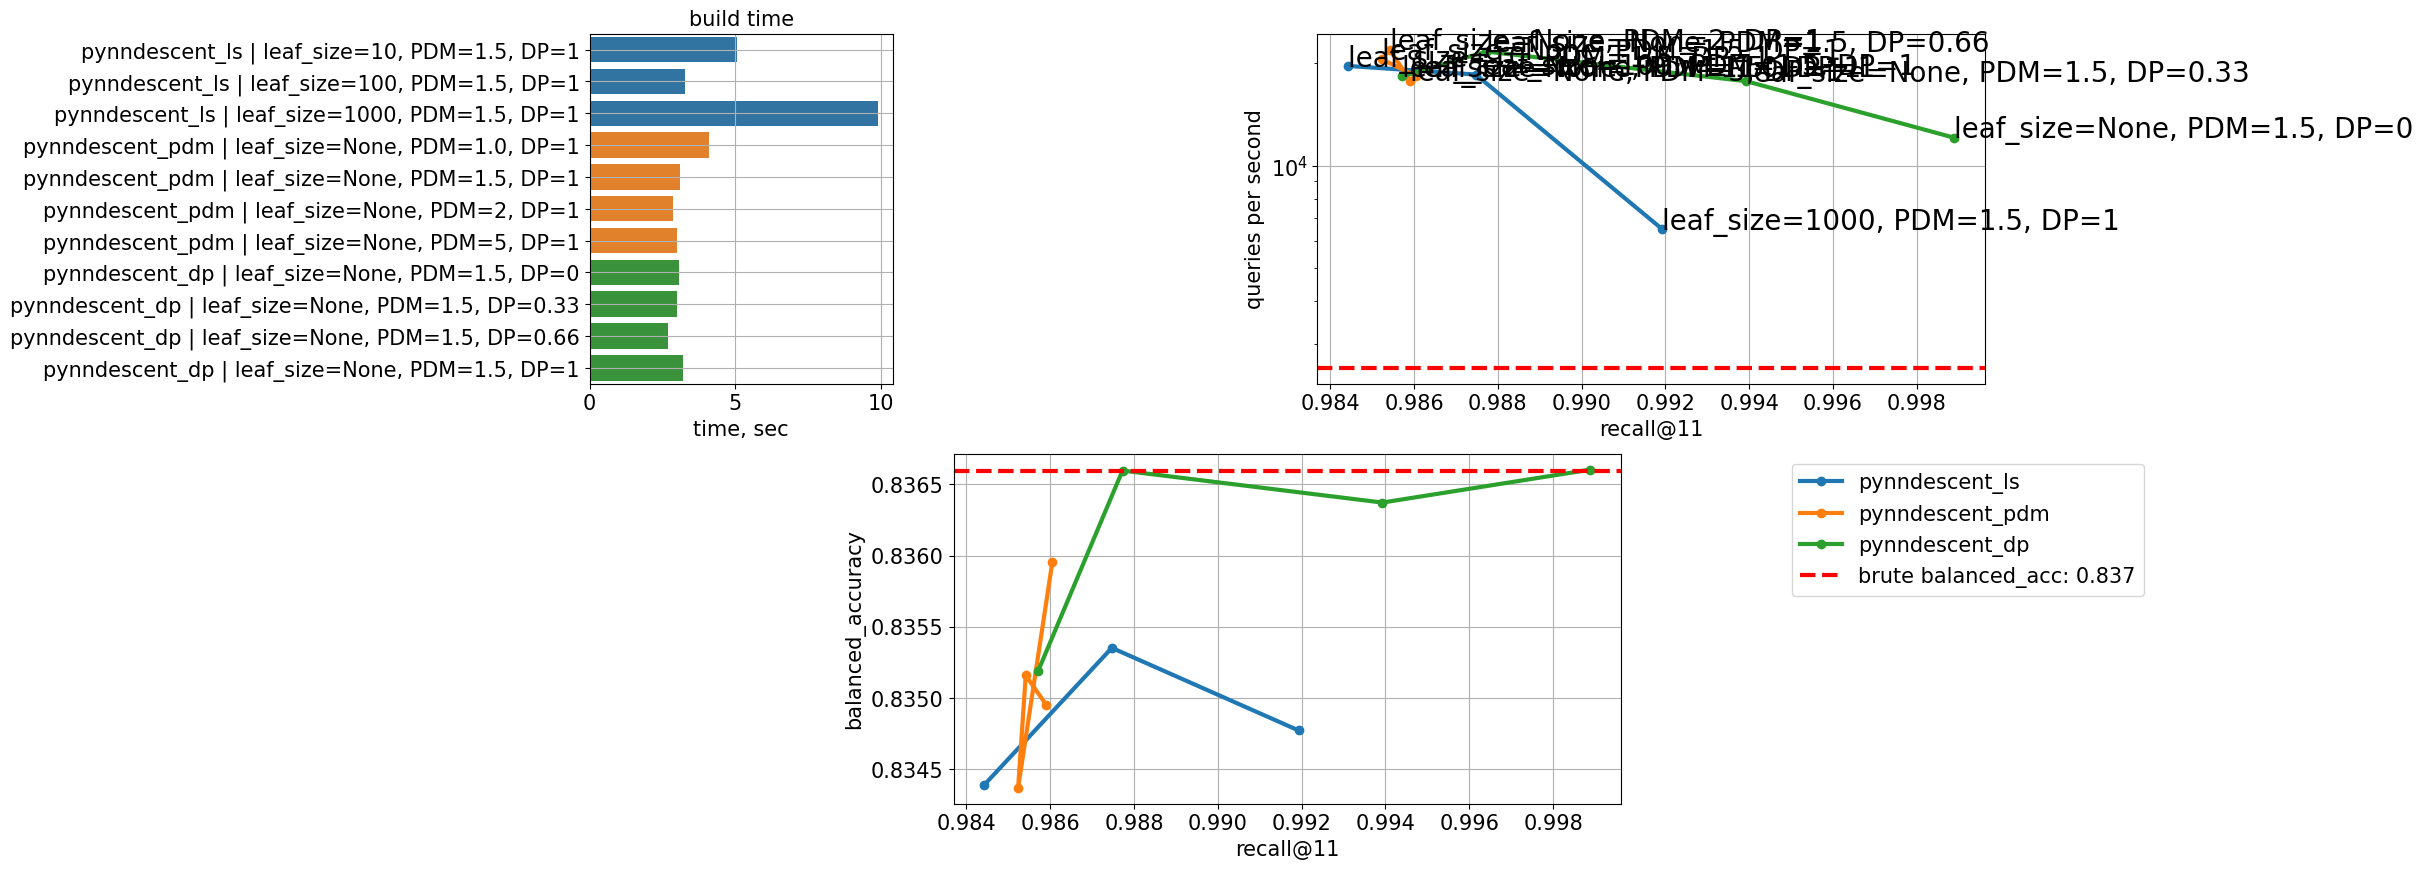

In [ ]:
pynndescent_plotter.show()

In [ ]:
%time plotter.prepare_pynndescent(X_val, y_val, name='pynndescent', pruning_degree_multiplier=[0, 1.5, 3])


pynndescent. leaf_size=None, PDM=0, DP=1 | build_time: 2.368 sec
pynndescent. | search_time: 0.047 sec

pynndescent. leaf_size=None, PDM=1.5, DP=1 | build_time: 2.522 sec
pynndescent. | search_time: 0.171 sec

pynndescent. leaf_size=None, PDM=3, DP=1 | build_time: 2.416 sec
pynndescent. | search_time: 0.171 sec
CPU times: total: 53 s
Wall time: 7.82 s


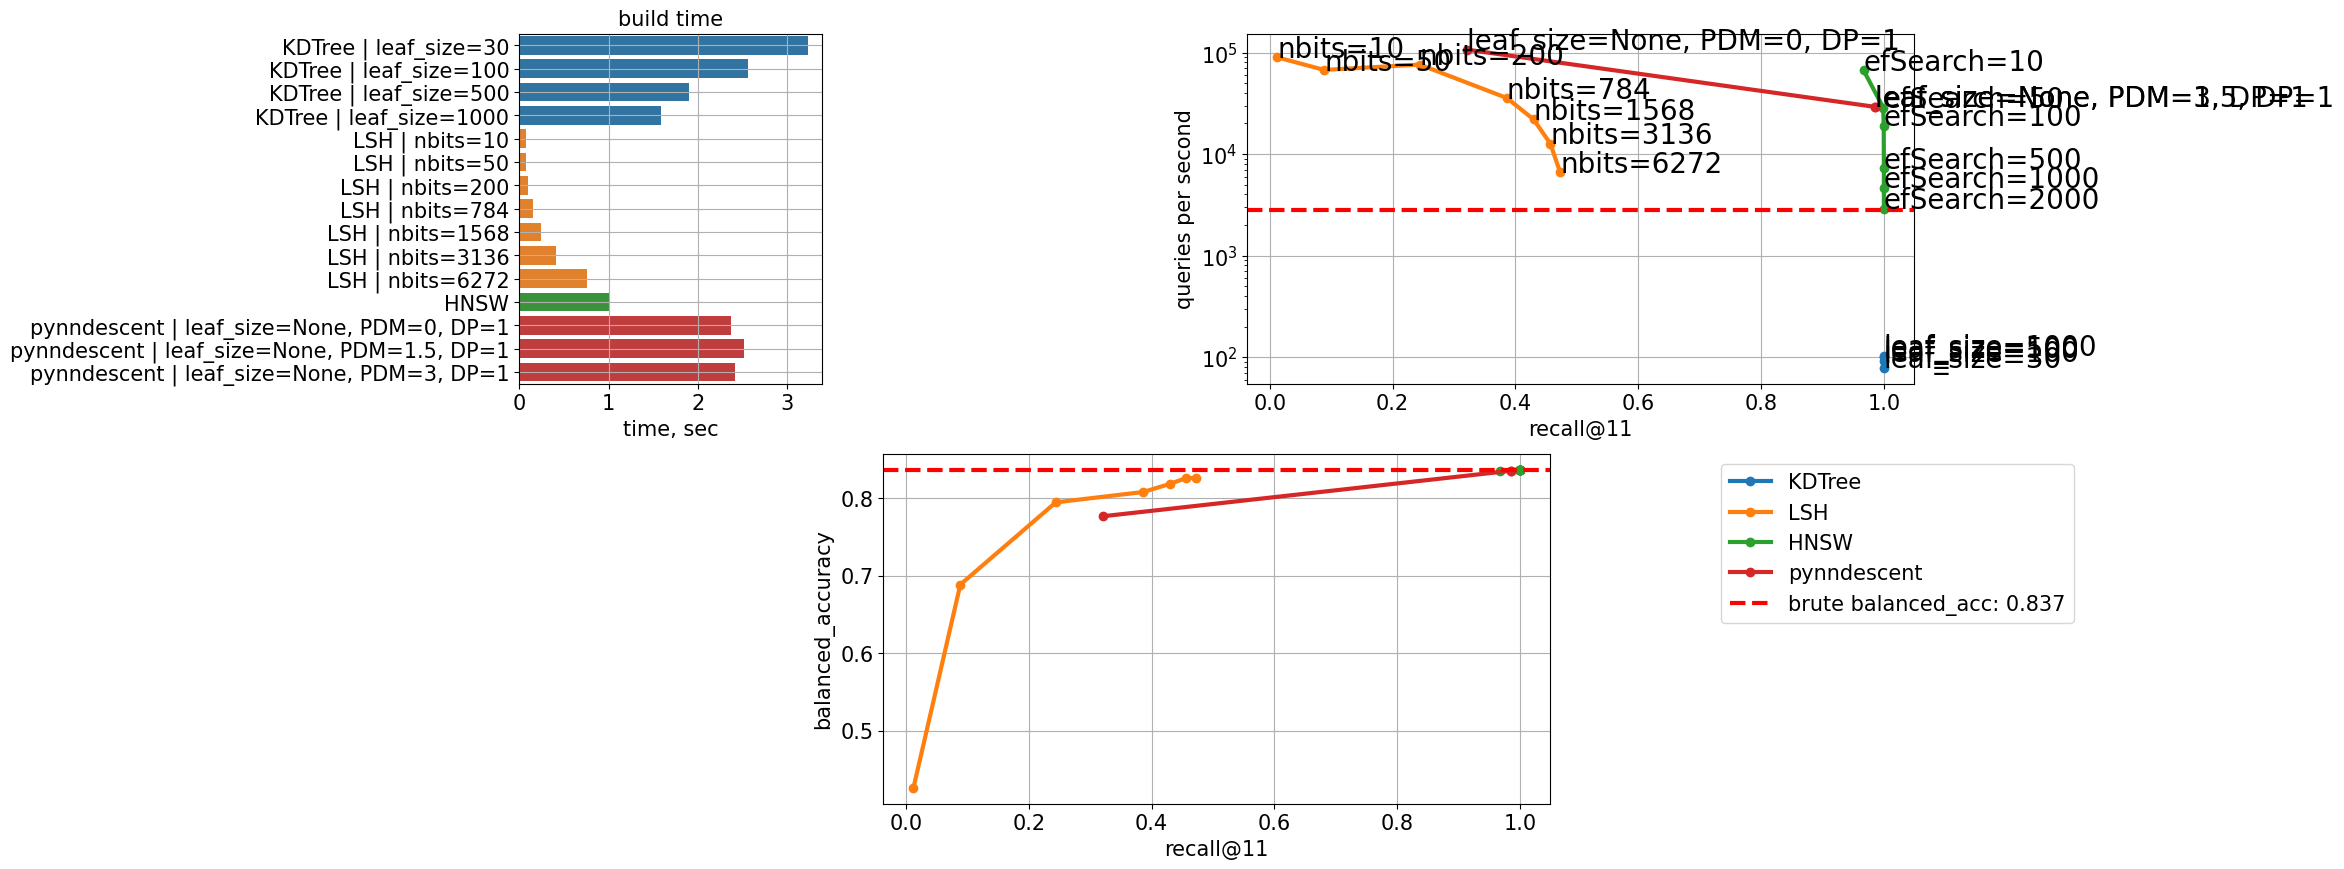

In [ ]:
plotter.show()

Проблемы:
1) хранение всей выборки + хранение графа
2) не самое быстрое построение индекса

Плюсы:
1) любые функции близости!
2) отличная точность
3) отличная скорость поиска

## Часть 7. faiss /╲/\╭( ͡°͡° ͜ʖ ͡°͡°)╮/\╱\ . Facebook AI research Similarity Search - заморочки на тему как бы не хранить данные
  
[**faiss**](https://github.com/facebookresearch/faiss) <br>
[faiss wiki](https://github.com/facebookresearch/faiss/wiki/)
  
2011- Product Quantization for Nearest Neighbor Search https://hal.inria.fr/inria-00514462v2/document

Разберем код:

In [ ]:
import faiss

# build the index
coarse_quantizer = faiss.IndexFlatL2(dim)

index = faiss.IndexIVFPQ(coarse_quantizer, # с помощью какого индекса считать соседство с центроидами (coarse и PQ)
                         dim, # d - размерность исходных векторов
                         1000, # nlists - k' для coarse quantizer
                         16, # m - на сколько векторов бить исходные в product quantizer
                         8 # nbits - количество бит на индексы центроидов для PQ, nbits = log_2 k*, то есть k* = 2^nbits
                        )


train_data = data.copy() # на практике это могут быть другие данные
timer = Timer()
index.train(data)
timer.tick('Training')


index.add(data) # add vectors to the index
timer.tick('Adding data to index')

k = 3
index.nprobe = 200
distances, labels = index.search(query, k)
timer.tick('Searching')

print('\nlabels:\n', labels[:5])
print('\ndistances:\n', distances[:5])

Training: 1.114 sec
Adding data to index: 0.121 sec
Searching: 0.042 sec

labels:
 [[    0 38000 61766]
 [    1 14877 60248]
 [    2 52428 42788]
 [    3 78943 20159]
 [    4 17942 44490]]

distances:
 [[ 2.5094013 11.537447  11.672835 ]
 [ 2.3773737 11.33806   11.456481 ]
 [ 2.8990593 12.785884  12.80067  ]
 [ 2.1038756 10.756303  11.655209 ]
 [ 2.5046978 12.219914  12.520722 ]]


Сравним между собой:

In [ ]:
faiss_plotter = AnnPlotter(X_tr, y_tr, k=11, metric='euclidean', n_classes=10)
faiss_plotter.calc_true_nn(X_val, y_val)

Brute | search_time: 2.045 sec


[`faiss.index_factory`](https://github.com/facebookresearch/faiss/wiki/The-index-factory) - удобный способ задать индекс со всеми прибамбасами в одну (1) строчку.

строка вида: `'[pre-processing],[IVF or Flat main index],[vector encoding],[refine step]'`

In [ ]:
nprobe_list = [10, 100, 400]
# faiss_plotter.prepare_faiss(X_val, y_val, name='faiss_IVFFlat', index_factory_str='IVF2000,Flat', nprobe=nprobe_list)
# faiss_plotter.prepare_faiss(X_val, y_val, name='faiss_IVFPQ', index_factory_str='IVF2000,PQ56x8', nprobe=nprobe_list)
# faiss_plotter.prepare_faiss(X_val, y_val, name='faiss_IMI', index_factory_str='IMI2x8,PQ56x8', nprobe=nprobe_list)
# faiss_plotter.prepare_faiss(X_val, y_val, name='faiss_IVFPQ + OPQ', index_factory_str='OPQ56,IVF2000,PQ56x8', nprobe=nprobe_list)
faiss_plotter.prepare_faiss(X_val, y_val, name='faiss_IVFPQR', index_factory_str='IVF2000,PQ28x8,Refine(PQ28x4)', nprobe=nprobe_list)
# faiss_plotter.prepare_faiss(X_val, y_val, name='faiss_IVFPQ + FastScan', index_factory_str='IVF2000,PQ56x4fs', nprobe=nprobe_list)


faiss_IVFPQR. IVF2000,PQ28x8,Refine(PQ28x8) | build_time: 20.075 sec
faiss_IVFPQR. nprobe=10 | search_time: 0.188 sec
faiss_IVFPQR. nprobe=100 | search_time: 0.193 sec
faiss_IVFPQR. nprobe=400 | search_time: 0.178 sec


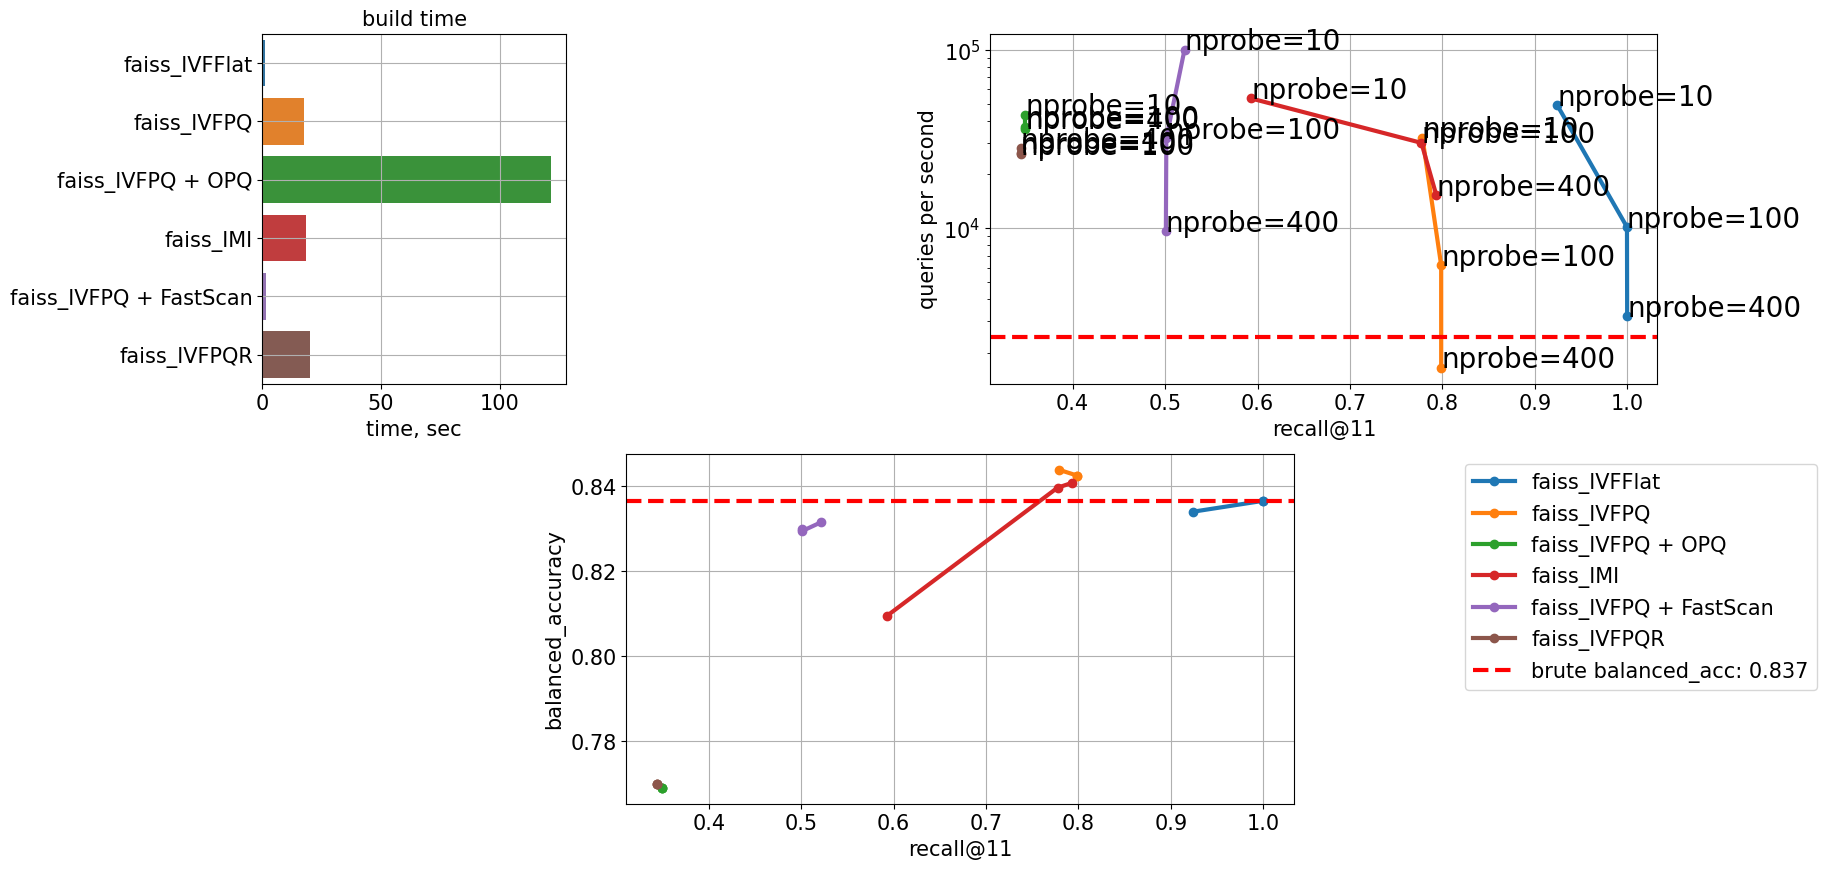

In [ ]:
faiss_plotter.show()

Сравним с остальными:


faiss_IMI. IMI2x8,PQ56x8 | build_time: 16.349 sec
faiss_IMI. nprobe=10 | search_time: 0.086 sec
faiss_IMI. nprobe=100 | search_time: 0.152 sec
faiss_IMI. nprobe=400 | search_time: 0.282 sec


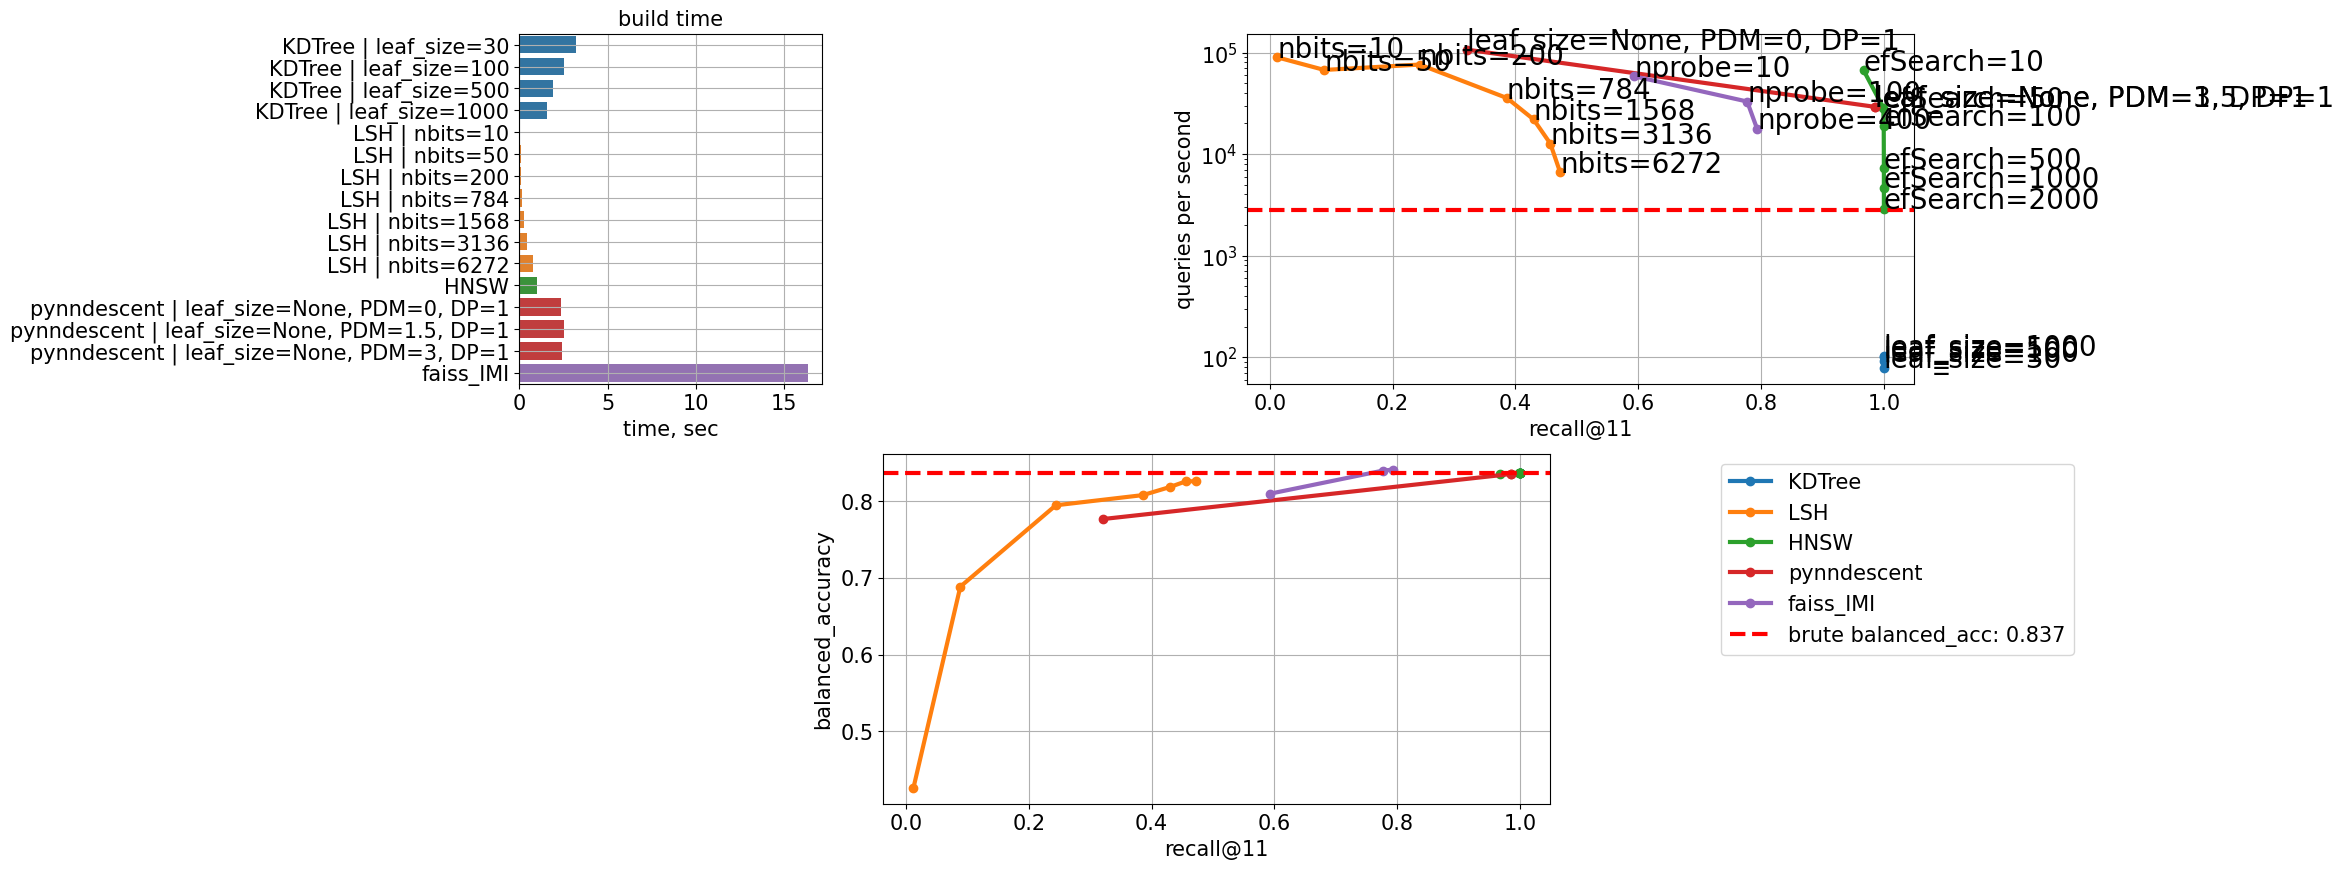

In [ ]:
plotter.prepare_faiss(X_val, y_val, name='faiss_IMI', index_factory_str='IMI2x8,PQ56x8', nprobe=nprobe_list)
plotter.show()